<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

***Some parts of the notebook are almost the copy of [ mmta-team course](https://github.com/mmta-team/mmta_fall_2020). Special thanks to mmta-team for making them publicly available. [Original notebook](https://github.com/mmta-team/mmta_fall_2020/blob/master/tasks/01_word_embeddings/task_word_embeddings.ipynb).***

<b> Прочитайте семинар, пожалуйста, для успешного выполнения домашнего задания. В конце ноутка напишите свой вывод. Работа без вывода оценивается ниже.

## Задача поиска схожих по смыслу предложений

Мы будем ранжировать вопросы [StackOverflow](https://stackoverflow.com) на основе семантического векторного представления 

До этого в курсе не было речи про задачу ранжировния, поэтому введем математическую формулировку

## Задача ранжирования(Learning to Rank)

* $X$ - множество объектов
* $X^l = \{x_1, x_2, ..., x_l\}$ - обучающая выборка
<br>На обучающей выборке задан порядок между некоторыми элементами, то есть нам известно, что некий объект выборки более релевантный для нас, чем другой:
* $i \prec j$ - порядок пары индексов объектов на выборке $X^l$ c индексами $i$ и $j$
### Задача:
построить ранжирующую функцию $a$ : $X \rightarrow R$ такую, что
$$i \prec j \Rightarrow a(x_i) < a(x_j)$$

<img src="https://d25skit2l41vkl.cloudfront.net/wp-content/uploads/2016/12/Featured-Image.jpg" width=500, height=450>

### Embeddings

Будем использовать предобученные векторные представления слов на постах Stack Overflow.<br>
[A word2vec model trained on Stack Overflow posts](https://github.com/vefstathiou/SO_word2vec)

In [1]:
import math

Dataset: https://zenodo.org/record/1199620/files/SO_vectors_200.bin?download=1

In [2]:
from gensim.models.keyedvectors import KeyedVectors
wv_embeddings = KeyedVectors.load_word2vec_format("../../datasets/SO_vectors_200.bin", binary=True)

In [3]:
outlier = wv_embeddings.doesnt_match(["python", "java", "c", "dog"])  # Находит "лишнее" слово в списке
outlier

'dog'

In [4]:
wv_embeddings.similarity('dog', 'cat')  # Возвращает коэффициент косинусной близости между двумя словами.

0.6852341

Косинусная сходство: 

![Косинусное сходство](https://avatars.mds.yandex.net/i?id=bb9eff763a532435d4cca4f948d40d74_l-5235567-images-thumbs&n=13)


In [5]:
wv_embeddings.index_to_key[0:10]

['use', 'code', 'using', 'like', 'will', 'want', 'need', 'get', 'file', 'one']

In [6]:
wv_embeddings.most_similar(positive=['django', 'python'], negative=['ruby'], topn=3)

[('web2py', 0.6115486025810242),
 ('flask', 0.5925045609474182),
 ('djangos', 0.5907748341560364)]

In [7]:
wv_embeddings.most_similar(positive=['pandas', 'python'], negative=['r'], topn=3)

[('pythons', 0.6542717218399048),
 ('pytables', 0.6075527667999268),
 ('python3', 0.5946738719940186)]

In [8]:
wv_embeddings[0].shape

(200,)

#### Как пользоваться этими векторами?

Посмотрим на примере одного слова, что из себя представляет embedding

In [9]:
word = 'dog'
if word in wv_embeddings:
    print(wv_embeddings[word].dtype, wv_embeddings[word].shape)

float32 (200,)


In [10]:
print(f"Num of words: {len(wv_embeddings.index_to_key)}")

Num of words: 1787145


Найдем наиболее близкие слова к слову `dog`:

In [11]:
wv_embeddings.most_similar(positive=['dog'], topn=5)

[('animal', 0.8564180135726929),
 ('dogs', 0.7880866527557373),
 ('mammal', 0.7623804211616516),
 ('cats', 0.7621253728866577),
 ('animals', 0.760793924331665)]

#### Вопрос 1:
* Входит ли слов `cat` топ-5 близких слов к слову `dog`? Какое место? 

In [12]:
for i, obj in enumerate(wv_embeddings.most_similar(positive=['cat'], topn=5)):
    word, similary = obj
    if 'dog' == word:
        print(f'top: {i + 1}, word: {word}, similary: {similary}')
        break

top: 2, word: dog, similary: 0.6852341890335083


### Векторные представления текста

Перейдем от векторных представлений отдельных слов к векторным представлениям вопросов, как к **среднему** векторов всех слов в вопросе. Если для какого-то слова нет предобученного вектора, то его нужно пропустить. Если вопрос не содержит ни одного известного слова, то нужно вернуть нулевой вектор.

In [92]:
import re
import numpy as np

# you can use your tokenizer
# for example, from nltk.tokenize import WordPunctTokenizer

class MyTokenizer:
    def __init__(self):
        pass
    def tokenize(self, text):
        return re.findall(r'\w+', text)
tokenizer = MyTokenizer()

In [93]:
def question_to_vec(question, embeddings, tokenizer, dim=200):
    """
        question: строка
        embeddings: наше векторное представление
        dim: размер любого вектора в нашем представлении
        
        return: векторное представление для вопроса
    """
    
    emb_means = []
    for word in tokenizer.tokenize(question):
        if word in embeddings:
            emb_means.append(embeddings[word])
    
    if len(emb_means) == 0:
        return np.zeros(dim)
    return np.array(emb_means, dtype='float32').mean(axis=0)

Теперь у нас есть метод для создания векторного представления любого предложения.

#### Вопрос 2:
* Какая третья(с индексом 2) компонента вектора предложения `I love neural networks` (округлите до 2 знаков после запятой)?

In [94]:
text = 'I love neural networks'

In [95]:
vector = question_to_vec(text, wv_embeddings, tokenizer)
vector

array([-1.0142275 , -1.6891261 , -1.2854122 , -1.3710302 ,  0.15916634,
        0.06706961,  1.1188413 , -0.07051762,  0.5386369 , -0.37139115,
        0.28913018,  1.03125   , -2.865466  , -1.3192873 ,  2.2098296 ,
        1.1678672 ,  1.0841951 ,  1.8467226 , -0.98733807,  0.8720946 ,
       -0.17219625,  0.73839015, -0.7827826 , -0.8827869 , -0.6152611 ,
       -0.15872358, -0.6170798 ,  0.36668167,  2.0137532 ,  0.2627472 ,
       -1.4950123 , -1.386715  , -1.2049937 , -1.016617  ,  2.7621174 ,
        1.7255713 , -0.19038178, -0.5899447 , -0.1141155 , -1.8890352 ,
       -1.7883505 , -0.20420384, -0.7062034 ,  2.489034  , -0.15452717,
        1.1255013 ,  0.2610835 ,  1.3153247 , -0.57667524, -0.3327141 ,
        1.6764902 ,  0.91229993, -0.69880134,  2.3752553 , -1.7634224 ,
        3.1378052 ,  1.2243204 , -1.0554415 ,  0.7897571 ,  0.04404024,
        1.1623045 , -0.4478023 , -0.9149816 ,  0.01501505, -0.85523087,
       -1.0183454 , -0.7162116 ,  1.0727204 ,  0.8881876 , -0.29

In [96]:
round(vector[2], 2)

-1.29

In [97]:
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()
vector = question_to_vec(text, wv_embeddings, tokenizer)
vector

array([-1.0142275 , -1.6891261 , -1.2854122 , -1.3710302 ,  0.15916634,
        0.06706961,  1.1188413 , -0.07051762,  0.5386369 , -0.37139115,
        0.28913018,  1.03125   , -2.865466  , -1.3192873 ,  2.2098296 ,
        1.1678672 ,  1.0841951 ,  1.8467226 , -0.98733807,  0.8720946 ,
       -0.17219625,  0.73839015, -0.7827826 , -0.8827869 , -0.6152611 ,
       -0.15872358, -0.6170798 ,  0.36668167,  2.0137532 ,  0.2627472 ,
       -1.4950123 , -1.386715  , -1.2049937 , -1.016617  ,  2.7621174 ,
        1.7255713 , -0.19038178, -0.5899447 , -0.1141155 , -1.8890352 ,
       -1.7883505 , -0.20420384, -0.7062034 ,  2.489034  , -0.15452717,
        1.1255013 ,  0.2610835 ,  1.3153247 , -0.57667524, -0.3327141 ,
        1.6764902 ,  0.91229993, -0.69880134,  2.3752553 , -1.7634224 ,
        3.1378052 ,  1.2243204 , -1.0554415 ,  0.7897571 ,  0.04404024,
        1.1623045 , -0.4478023 , -0.9149816 ,  0.01501505, -0.85523087,
       -1.0183454 , -0.7162116 ,  1.0727204 ,  0.8881876 , -0.29

In [98]:
round(vector[2], 2)

-1.29

### Оценка близости текстов

Представим, что мы используем идеальные векторные представления слов. Тогда косинусное расстояние между дублирующими предложениями должно быть меньше, чем между случайно взятыми предложениями. 

Сгенерируем для каждого из $N$ вопросов $R$ случайных отрицательных примеров и примешаем к ним также настоящие дубликаты. Для каждого вопроса будем ранжировать с помощью нашей модели $R + 1$ примеров и смотреть на позицию дубликата. Мы хотим, чтобы дубликат был первым в ранжированном списке.

#### Hits@K
Первой простой метрикой будет количество корректных попаданий для какого-то $K$:
$$ \text{Hits@K} = \frac{1}{N}\sum_{i=1}^N \, [rank\_q_i^{'} \le K],$$
* $\begin{equation*}
[x < 0 ] \equiv 
 \begin{cases}
   1, &x < 0\\
   0, &x \geq 0
 \end{cases}
\end{equation*}$ - индикаторная функция
* $q_i$ - $i$-ый вопрос
* $q_i^{'}$ - его дубликат
* $rank\_q_i^{'}$ - позиция дубликата в ранжированном списке ближайших предложений для вопроса $q_i$.

#### DCG@K
Второй метрикой будет упрощенная DCG метрика, учитывающая порядок элементов в списке путем домножения релевантности элемента на вес равный обратному логарифму номера позиции::
$$ \text{DCG@K} = \frac{1}{N} \sum_{i=1}^N\frac{1}{\log_2(1+rank\_q_i^{'})}\cdot[rank\_q_i^{'} \le K],$$
С такой метрикой модель штрафуется за большой ранк корректного ответа

#### Вопрос 3:
* Максимум `Hits@47 - DCG@1`?

1 - min(DCG)? min(DSG) = 0 => Ответ: 1.

<img src='https://hsto.org/files/1c5/edf/dee/1c5edfdeebce4b71a86bdf986d9f88f2.jpg' width=400, height=200>

#### Пример оценок

Вычислим описанные выше метрики для игрушечного примера. 
Пусть
* $N = 1$, $R = 3$
* <font color='green'>"Что такое python?"</font> - вопрос $q_1$
* <font color='red'>"Что такое язык python?"</font> - его дубликат $q_i^{'}$

Пусть модель выдала следующий ранжированный список кандидатов:

1. "Как изучить с++?"
2. <font color='red'>"Что такое язык python?"</font>
3. "Хочу учить Java"
4. "Не понимаю Tensorflow"

$\Rightarrow rank\_q_i^{'} = 2$

Вычислим метрику *Hits@K* для *K = 1, 4*:

- [K = 1] $\text{Hits@1} =  [rank\_q_i^{'} \le 1] = 0$
- [K = 4] $\text{Hits@4} =  [rank\_q_i^{'} \le 4] = 1$

Вычислим метрику *DCG@K* для *K = 1, 4*:
- [K = 1] $\text{DCG@1} = \frac{1}{\log_2(1+2)}\cdot[2 \le 1] = 0$
- [K = 4] $\text{DCG@4} = \frac{1}{\log_2(1+2)}\cdot[2 \le 4] = \frac{1}{\log_2{3}}$

#### Вопрос 4:
* Вычислите `DCG@10`, если $rank\_q_i^{'} = 9$(округлите до одного знака после запятой)

- [K = 10] $\text{DCG@10} = \frac{1}{\log_2(1+9)}\cdot[9 \le 10] = \frac{1}{\log_2{10}} \approx 0,3$

### HITS\_COUNT и DCG\_SCORE

Каждая функция имеет два аргумента: $dup\_ranks$ и $k$. $dup\_ranks$ является списком, который содержит рейтинги дубликатов(их позиции в ранжированном списке). Например, $dup\_ranks = [2]$ для примера, описанного выше.

In [99]:
def hits_count(dup_ranks, k):
    """
        dup_ranks: list индексов дубликатов
        result: вернуть  Hits@k
    """
    
    return sum(rank_qi <= k for rank_qi in dup_ranks) / len(dup_ranks)

In [100]:
def dcg_score(dup_ranks, k):
    """
        dup_ranks: list индексов дубликатов
        result: вернуть DCG@k
    """

    return sum((1 / math.log2(1 + rank_qi)) if rank_qi <= k else 0 for rank_qi in dup_ranks) / len(dup_ranks)

Протестируем функции. Пусть $N = 1$, то есть один эксперимент. Будем искать копию вопроса и оценивать метрики.

In [101]:
import pandas as pd

In [102]:
copy_answers = ["How does the catch keyword determine the type of exception that was thrown",]

# наши кандидаты
candidates_ranking = [["How Can I Make These Links Rotate in PHP",
                       "How does the catch keyword determine the type of exception that was thrown",
                       "NSLog array description not memory address",
                       "PECL_HTTP not recognised php ubuntu"],]
# dup_ranks — позиции наших копий, так как эксперимент один, то этот массив длины 1
dup_ranks = [2]

# вычисляем метрику для разных k
print('Ваш ответ HIT:', [hits_count(dup_ranks, k) for k in range(1, 5)])
print('Ваш ответ DCG:', [round(dcg_score(dup_ranks, k), 5) for k in range(1, 5)])

Ваш ответ HIT: [0.0, 1.0, 1.0, 1.0]
Ваш ответ DCG: [0.0, 0.63093, 0.63093, 0.63093]


У вас должно получиться

In [103]:
# correct_answers - метрика для разных k
correct_answers = pd.DataFrame([[0, 1, 1, 1], [0, 1 / (np.log2(3)), 1 / (np.log2(3)), 1 / (np.log2(3))]],
                               index=['HITS', 'DCG'], columns=range(1,5))
correct_answers

,1,2,3,4
HITS,0,1.00000,1.00000,1.00000
DCG,0,0.63093,0.63093,0.63093


### Данные
[arxiv link](https://drive.google.com/file/d/1QqT4D0EoqJTy7v9VrNCYD-m964XZFR7_/edit)

`train.tsv` - выборка для обучения.<br> В каждой строке через табуляцию записаны: **<вопрос>, <похожий вопрос>**

`validation.tsv` - тестовая выборка.<br> В каждой строке через табуляцию записаны: **<вопрос>, <похожий вопрос>, <отрицательный пример 1>, <отрицательный пример 2>, ...**

!unzip stackoverflow_similar_questions.zip

Считайте данные.

In [104]:
def read_corpus(filename):
    data = []
    for line in open(filename, encoding='utf-8'):
        data.append(line.strip().split('\t'))
    return data

Нам понадобиться только файл validation.

In [105]:
validation_data = read_corpus('../../datasets/validation.tsv')

Кол-во строк

In [106]:
len(validation_data)

3760

Размер нескольких первых строк

In [107]:
for i in range(5):
    print(i + 1, len(validation_data[i]))

1 1001
2 1001
3 1001
4 1001
5 1001


### Ранжирование без обучения

Реализуйте функцию ранжирования кандидатов на основе косинусного расстояния. Функция должна по списку кандидатов вернуть отсортированный список пар (позиция в исходном списке кандидатов, кандидат). При этом позиция кандидата в полученном списке является его рейтингом (первый - лучший). Например, если исходный список кандидатов был [a, b, c], и самый похожий на исходный вопрос среди них - c, затем a, и в конце b, то функция должна вернуть список **[(2, c), (0, a), (1, b)]**.

In [108]:
from sklearn.metrics.pairwise import cosine_similarity
from copy import deepcopy

In [109]:
def rank_candidates(question, candidates, embeddings, tokenizer, dim=200):
    """
        question: строка
        candidates: массив строк(кандидатов) [a, b, c]
        result: пары (начальная позиция, кандидат) [(2, c), (0, a), (1, b)]
    """
    
    q_vec = question_to_vec(question, embeddings, tokenizer, dim=dim)
    
    candidate_vectors = [question_to_vec(candidate, embeddings, tokenizer, dim=dim) for candidate in candidates]
    result = ((i, cs, candidates[i]) for i, cs in enumerate(cosine_similarity([q_vec], candidate_vectors)[0]))
    sorted_result = sorted(result, key=lambda x: x[1], reverse=True)
    return [(x[0], x[2]) for x in sorted_result]
    

Протестируйте работу функции на примерах ниже. Пусть $N=2$, то есть два эксперимента

In [110]:
questions = ['converting string to list', 'Sending array via Ajax fails'] 

candidates = [['Convert Google results object (pure js) to Python object', # первый эксперимент
               'C# create cookie from string and send it',
               'How to use jQuery AJAX for an outside domain?'],
              
              ['Getting all list items of an unordered list in PHP',      # второй эксперимент
               'WPF- How to update the changes in list item of a list',
               'select2 not displaying search results']]

In [111]:
tokenizer = MyTokenizer()

for question, q_candidates in zip(questions, candidates):
        ranks = rank_candidates(question, q_candidates, wv_embeddings, tokenizer)
        print(ranks)
        print()

[(1, 'C# create cookie from string and send it'), (0, 'Convert Google results object (pure js) to Python object'), (2, 'How to use jQuery AJAX for an outside domain?')]

[(1, 'WPF- How to update the changes in list item of a list'), (0, 'Getting all list items of an unordered list in PHP'), (2, 'select2 not displaying search results')]



Для первого экперимента вы можете полностью сравнить ваши ответы и правильные ответы. Но для второго эксперимента два ответа на кандидаты будут <b>скрыты</b>(*)

должно вывести
```
results = [[(1, 'C# create cookie from string and send it'),
            (0, 'Convert Google results object (pure js) to Python object'),
            (2, 'How to use jQuery AJAX for an outside domain?')],
           [(*, 'Getting all list items of an unordered list in PHP'), #скрыт
            (*, 'select2 not displaying search results'), #скрыт
            (*, 'WPF- How to update the changes in list item of a list')]] #скрыт
```

Последовательность начальных индексов вы должны получить `для эксперимента 1`  1, 0, 2.

#### Вопрос 5:
* Какую последовательность начальных индексов вы получили `для эксперимента 2`(перечисление без запятой и пробелов, например, `102` для первого эксперимента?

Ответ: 102

Теперь мы можем оценить качество нашего метода. Запустите следующие два блока кода для получения результата. Обратите внимание, что вычисление расстояния между векторами занимает некоторое время (примерно 10 минут). Можете взять для validation 1000 примеров.

In [112]:
from tqdm import tqdm

In [119]:
wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, wv_embeddings, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)

 27%|██▋       | 1000/3760 [00:27<01:15, 36.77it/s]


In [118]:
for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

100%|██████████| 6/6 [00:00<00:00, 6003.30it/s]

DCG@   1: 0.276 | Hits@   1: 0.276
DCG@   5: 0.332 | Hits@   5: 0.386
DCG@  10: 0.349 | Hits@  10: 0.438
DCG@ 100: 0.395 | Hits@ 100: 0.671
DCG@ 500: 0.421 | Hits@ 500: 0.875
DCG@1000: 0.434 | Hits@1000: 1.000


### Эмбеддинги, обученные на корпусе похожих вопросов

In [115]:
train_data = read_corpus('../../datasets/train.tsv')
train_data

[['converting string to list',
  'Convert Google results object (pure js) to Python object'],
 ['Which HTML 5 Canvas Javascript to use for making an interactive drawing tool?',
  'Event handling for geometries in Three.js?'],
 ['Sending array via Ajax fails',
  'Getting all list items of an unordered list in PHP'],
 ['How to insert CookieCollection to CookieContainer?',
  'C# create cookie from string and send it'],
 ['Updating one element of a bound Observable collection',
  'WPF- How to update the changes in list item of a list'],
 ['MongoDB error on find()',
  'Retrieve only the queried element in an object array in MongoDB collection'],
 ['select2 not displaying search results',
  'How to use jQuery AJAX for an outside domain?'],
 ['Using Reduce to merge multiple data frames with passing arguments and without defining function outside the Reduce (syntax)',
  'R - merge a list of data frames into one data frame with missing values by row'],
 ['Adding Prototype to JavaScript Object L

Улучшите качество модели.<br>Склеим вопросы в пары и обучим на них модель Word2Vec из gensim. Выберите размер window. Объясните свой выбор.

**Используем объединённые пары вопросов без `lower()` и лемматизации**

In [122]:
tokenizer = WordPunctTokenizer()

words = [tokenizer.tokenize(" ".join(questions)) for questions in train_data]

In [124]:
from gensim.models import Word2Vec

dsg_history = []
hits_history = []
for min_count in range(1, 6):
    for window in range(1, 8):
        embeddings_trained = Word2Vec(words, # data for model to train on
                         vector_size=200,                 # embedding vector size
                         min_count=min_count,                     # consider words that occured at least 5 times
                         window=window).wv
        
        wv_ranking = []
        max_validation_examples = 1000
        for i, line in enumerate(tqdm(validation_data)):
            if i == max_validation_examples:
                break
            q, *ex = line
            ranks = rank_candidates(q, ex, embeddings_trained, tokenizer)
            wv_ranking.append([r[0] for r in ranks].index(0) + 1)
            
        print(f'min_count: {min_count}, window: {window}')
        for k in tqdm([1, 5, 10, 100, 500, 1000]):
            dsg_score_num = dcg_score(wv_ranking, k)
            hits_score_num = hits_count(wv_ranking, k)
            dsg_history.append(dsg_score_num)
            hits_history.append(hits_score_num)
            print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dsg_score_num, k, hits_score_num))

 27%|██▋       | 1000/3760 [00:30<01:24, 32.53it/s]


min_count: 1, window: 1


100%|██████████| 6/6 [00:00<00:00, 2997.72it/s]


DCG@   1: 0.201 | Hits@   1: 0.201
DCG@   5: 0.260 | Hits@   5: 0.314
DCG@  10: 0.278 | Hits@  10: 0.370
DCG@ 100: 0.319 | Hits@ 100: 0.577
DCG@ 500: 0.353 | Hits@ 500: 0.846
DCG@1000: 0.369 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:31<01:25, 32.17it/s]


min_count: 1, window: 2


100%|██████████| 6/6 [00:00<00:00, 5997.57it/s]


DCG@   1: 0.226 | Hits@   1: 0.226
DCG@   5: 0.283 | Hits@   5: 0.335
DCG@  10: 0.301 | Hits@  10: 0.391
DCG@ 100: 0.352 | Hits@ 100: 0.646
DCG@ 500: 0.381 | Hits@ 500: 0.878
DCG@1000: 0.394 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:30<01:25, 32.43it/s]


min_count: 1, window: 3


100%|██████████| 6/6 [00:00<00:00, 2999.50it/s]


DCG@   1: 0.241 | Hits@   1: 0.241
DCG@   5: 0.306 | Hits@   5: 0.366
DCG@  10: 0.323 | Hits@  10: 0.419
DCG@ 100: 0.374 | Hits@ 100: 0.674
DCG@ 500: 0.404 | Hits@ 500: 0.908
DCG@1000: 0.414 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:30<01:24, 32.57it/s]


min_count: 1, window: 4


100%|██████████| 6/6 [00:00<00:00, 6001.87it/s]


DCG@   1: 0.252 | Hits@   1: 0.252
DCG@   5: 0.315 | Hits@   5: 0.373
DCG@  10: 0.332 | Hits@  10: 0.425
DCG@ 100: 0.387 | Hits@ 100: 0.696
DCG@ 500: 0.416 | Hits@ 500: 0.922
DCG@1000: 0.424 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:31<01:27, 31.61it/s]


min_count: 1, window: 5


100%|██████████| 6/6 [00:00<00:00, 5994.72it/s]


DCG@   1: 0.260 | Hits@   1: 0.260
DCG@   5: 0.326 | Hits@   5: 0.386
DCG@  10: 0.343 | Hits@  10: 0.441
DCG@ 100: 0.399 | Hits@ 100: 0.717
DCG@ 500: 0.425 | Hits@ 500: 0.925
DCG@1000: 0.433 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:31<01:27, 31.47it/s]


min_count: 1, window: 6


100%|██████████| 6/6 [00:00<00:00, 3002.72it/s]


DCG@   1: 0.257 | Hits@   1: 0.257
DCG@   5: 0.329 | Hits@   5: 0.394
DCG@  10: 0.346 | Hits@  10: 0.448
DCG@ 100: 0.402 | Hits@ 100: 0.722
DCG@ 500: 0.428 | Hits@ 500: 0.928
DCG@1000: 0.436 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:42<01:57, 23.42it/s]


min_count: 1, window: 7


100%|██████████| 6/6 [00:00<00:00, 2997.72it/s]


DCG@   1: 0.263 | Hits@   1: 0.263
DCG@   5: 0.331 | Hits@   5: 0.392
DCG@  10: 0.351 | Hits@  10: 0.454
DCG@ 100: 0.406 | Hits@ 100: 0.724
DCG@ 500: 0.432 | Hits@ 500: 0.930
DCG@1000: 0.439 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:41<01:54, 24.01it/s]


min_count: 2, window: 1


100%|██████████| 6/6 [00:00<00:00, 1999.03it/s]


DCG@   1: 0.212 | Hits@   1: 0.212
DCG@   5: 0.269 | Hits@   5: 0.321
DCG@  10: 0.289 | Hits@  10: 0.383
DCG@ 100: 0.330 | Hits@ 100: 0.596
DCG@ 500: 0.362 | Hits@ 500: 0.848
DCG@1000: 0.378 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:45<02:04, 22.14it/s]


min_count: 2, window: 2


100%|██████████| 6/6 [00:00<00:00, 3002.01it/s]


DCG@   1: 0.231 | Hits@   1: 0.231
DCG@   5: 0.287 | Hits@   5: 0.338
DCG@  10: 0.305 | Hits@  10: 0.394
DCG@ 100: 0.357 | Hits@ 100: 0.652
DCG@ 500: 0.387 | Hits@ 500: 0.888
DCG@1000: 0.399 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:43<01:59, 23.06it/s]


min_count: 2, window: 3


100%|██████████| 6/6 [00:00<00:00, 2999.86it/s]


DCG@   1: 0.249 | Hits@   1: 0.249
DCG@   5: 0.308 | Hits@   5: 0.364
DCG@  10: 0.325 | Hits@  10: 0.417
DCG@ 100: 0.379 | Hits@ 100: 0.684
DCG@ 500: 0.408 | Hits@ 500: 0.910
DCG@1000: 0.418 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:45<02:04, 22.18it/s]


min_count: 2, window: 4


100%|██████████| 6/6 [00:00<00:00, 6007.60it/s]


DCG@   1: 0.257 | Hits@   1: 0.257
DCG@   5: 0.317 | Hits@   5: 0.375
DCG@  10: 0.339 | Hits@  10: 0.442
DCG@ 100: 0.392 | Hits@ 100: 0.711
DCG@ 500: 0.419 | Hits@ 500: 0.920
DCG@1000: 0.427 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:45<02:05, 21.96it/s]


min_count: 2, window: 5


100%|██████████| 6/6 [00:00<00:00, 1999.67it/s]


DCG@   1: 0.253 | Hits@   1: 0.253
DCG@   5: 0.324 | Hits@   5: 0.389
DCG@  10: 0.343 | Hits@  10: 0.450
DCG@ 100: 0.397 | Hits@ 100: 0.720
DCG@ 500: 0.424 | Hits@ 500: 0.930
DCG@1000: 0.431 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:43<02:00, 22.97it/s]


min_count: 2, window: 6


100%|██████████| 6/6 [00:00<00:00, 3003.44it/s]


DCG@   1: 0.264 | Hits@   1: 0.264
DCG@   5: 0.330 | Hits@   5: 0.391
DCG@  10: 0.350 | Hits@  10: 0.454
DCG@ 100: 0.405 | Hits@ 100: 0.723
DCG@ 500: 0.431 | Hits@ 500: 0.930
DCG@1000: 0.439 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:41<01:55, 23.92it/s]


min_count: 2, window: 7


100%|██████████| 6/6 [00:00<00:00, 1999.35it/s]


DCG@   1: 0.268 | Hits@   1: 0.268
DCG@   5: 0.337 | Hits@   5: 0.400
DCG@  10: 0.356 | Hits@  10: 0.460
DCG@ 100: 0.410 | Hits@ 100: 0.729
DCG@ 500: 0.435 | Hits@ 500: 0.927
DCG@1000: 0.443 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:45<02:06, 21.80it/s]


min_count: 3, window: 1


100%|██████████| 6/6 [00:00<00:00, 6000.43it/s]


DCG@   1: 0.218 | Hits@   1: 0.218
DCG@   5: 0.276 | Hits@   5: 0.329
DCG@  10: 0.292 | Hits@  10: 0.380
DCG@ 100: 0.337 | Hits@ 100: 0.606
DCG@ 500: 0.369 | Hits@ 500: 0.860
DCG@1000: 0.384 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:50<02:20, 19.65it/s]


min_count: 3, window: 2


100%|██████████| 6/6 [00:00<00:00, 3000.58it/s]


DCG@   1: 0.236 | Hits@   1: 0.236
DCG@   5: 0.292 | Hits@   5: 0.344
DCG@  10: 0.309 | Hits@  10: 0.397
DCG@ 100: 0.361 | Hits@ 100: 0.649
DCG@ 500: 0.392 | Hits@ 500: 0.893
DCG@1000: 0.403 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:52<02:25, 18.96it/s]


min_count: 3, window: 3


100%|██████████| 6/6 [00:00<00:00, 1000.19it/s]


DCG@   1: 0.248 | Hits@   1: 0.248
DCG@   5: 0.307 | Hits@   5: 0.363
DCG@  10: 0.325 | Hits@  10: 0.418
DCG@ 100: 0.378 | Hits@ 100: 0.681
DCG@ 500: 0.408 | Hits@ 500: 0.909
DCG@1000: 0.417 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:49<02:16, 20.27it/s]


min_count: 3, window: 4


100%|██████████| 6/6 [00:00<00:00, 3000.93it/s]


DCG@   1: 0.250 | Hits@   1: 0.250
DCG@   5: 0.317 | Hits@   5: 0.377
DCG@  10: 0.336 | Hits@  10: 0.436
DCG@ 100: 0.390 | Hits@ 100: 0.708
DCG@ 500: 0.418 | Hits@ 500: 0.925
DCG@1000: 0.426 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:47<02:10, 21.07it/s]


min_count: 3, window: 5


100%|██████████| 6/6 [00:00<00:00, 6007.60it/s]


DCG@   1: 0.260 | Hits@   1: 0.260
DCG@   5: 0.325 | Hits@   5: 0.388
DCG@  10: 0.342 | Hits@  10: 0.441
DCG@ 100: 0.399 | Hits@ 100: 0.723
DCG@ 500: 0.426 | Hits@ 500: 0.933
DCG@1000: 0.433 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:48<02:13, 20.68it/s]


min_count: 3, window: 6


100%|██████████| 6/6 [00:00<00:00, 1501.72it/s]


DCG@   1: 0.263 | Hits@   1: 0.263
DCG@   5: 0.332 | Hits@   5: 0.397
DCG@  10: 0.349 | Hits@  10: 0.451
DCG@ 100: 0.404 | Hits@ 100: 0.724
DCG@ 500: 0.430 | Hits@ 500: 0.928
DCG@1000: 0.438 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:48<02:15, 20.43it/s]


min_count: 3, window: 7


100%|██████████| 6/6 [00:00<00:00, 5994.72it/s]


DCG@   1: 0.269 | Hits@   1: 0.269
DCG@   5: 0.336 | Hits@   5: 0.397
DCG@  10: 0.356 | Hits@  10: 0.459
DCG@ 100: 0.409 | Hits@ 100: 0.723
DCG@ 500: 0.436 | Hits@ 500: 0.927
DCG@1000: 0.444 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:40<01:53, 24.40it/s]


min_count: 4, window: 1


100%|██████████| 6/6 [00:00<00:00, 3002.01it/s]


DCG@   1: 0.216 | Hits@   1: 0.216
DCG@   5: 0.276 | Hits@   5: 0.329
DCG@  10: 0.294 | Hits@  10: 0.384
DCG@ 100: 0.337 | Hits@ 100: 0.609
DCG@ 500: 0.369 | Hits@ 500: 0.860
DCG@1000: 0.384 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:44<02:02, 22.58it/s]


min_count: 4, window: 2


100%|██████████| 6/6 [00:00<00:00, 5997.57it/s]


DCG@   1: 0.235 | Hits@   1: 0.235
DCG@   5: 0.291 | Hits@   5: 0.342
DCG@  10: 0.307 | Hits@  10: 0.392
DCG@ 100: 0.360 | Hits@ 100: 0.652
DCG@ 500: 0.390 | Hits@ 500: 0.889
DCG@1000: 0.402 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:45<02:04, 22.15it/s]


min_count: 4, window: 3


100%|██████████| 6/6 [00:00<00:00, 3003.08it/s]


DCG@   1: 0.248 | Hits@   1: 0.248
DCG@   5: 0.309 | Hits@   5: 0.368
DCG@  10: 0.324 | Hits@  10: 0.414
DCG@ 100: 0.379 | Hits@ 100: 0.685
DCG@ 500: 0.407 | Hits@ 500: 0.911
DCG@1000: 0.417 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:46<02:07, 21.69it/s]


min_count: 4, window: 4


100%|██████████| 6/6 [00:00<00:00, 2001.42it/s]


DCG@   1: 0.247 | Hits@   1: 0.247
DCG@   5: 0.316 | Hits@   5: 0.381
DCG@  10: 0.334 | Hits@  10: 0.437
DCG@ 100: 0.388 | Hits@ 100: 0.706
DCG@ 500: 0.415 | Hits@ 500: 0.922
DCG@1000: 0.424 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:42<01:57, 23.40it/s]


min_count: 4, window: 5


100%|██████████| 6/6 [00:00<00:00, 3001.65it/s]


DCG@   1: 0.251 | Hits@   1: 0.251
DCG@   5: 0.321 | Hits@   5: 0.385
DCG@  10: 0.341 | Hits@  10: 0.447
DCG@ 100: 0.395 | Hits@ 100: 0.719
DCG@ 500: 0.422 | Hits@ 500: 0.927
DCG@1000: 0.429 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:44<02:03, 22.42it/s]


min_count: 4, window: 6


100%|██████████| 6/6 [00:00<00:00, 3002.72it/s]


DCG@   1: 0.258 | Hits@   1: 0.258
DCG@   5: 0.330 | Hits@   5: 0.396
DCG@  10: 0.347 | Hits@  10: 0.450
DCG@ 100: 0.403 | Hits@ 100: 0.727
DCG@ 500: 0.429 | Hits@ 500: 0.930
DCG@1000: 0.437 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:44<02:01, 22.63it/s]


min_count: 4, window: 7


100%|██████████| 6/6 [00:00<00:00, 3002.72it/s]


DCG@   1: 0.264 | Hits@   1: 0.264
DCG@   5: 0.335 | Hits@   5: 0.399
DCG@  10: 0.354 | Hits@  10: 0.461
DCG@ 100: 0.408 | Hits@ 100: 0.728
DCG@ 500: 0.435 | Hits@ 500: 0.934
DCG@1000: 0.442 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:40<01:51, 24.83it/s]


min_count: 5, window: 1


100%|██████████| 6/6 [00:00<00:00, 2999.14it/s]


DCG@   1: 0.220 | Hits@   1: 0.220
DCG@   5: 0.276 | Hits@   5: 0.323
DCG@  10: 0.294 | Hits@  10: 0.380
DCG@ 100: 0.341 | Hits@ 100: 0.615
DCG@ 500: 0.372 | Hits@ 500: 0.867
DCG@1000: 0.386 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:31<01:27, 31.69it/s]


min_count: 5, window: 2


100%|██████████| 6/6 [00:00<00:00, 6020.53it/s]


DCG@   1: 0.230 | Hits@   1: 0.230
DCG@   5: 0.290 | Hits@   5: 0.346
DCG@  10: 0.306 | Hits@  10: 0.397
DCG@ 100: 0.359 | Hits@ 100: 0.660
DCG@ 500: 0.388 | Hits@ 500: 0.894
DCG@1000: 0.400 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:31<01:25, 32.15it/s]


min_count: 5, window: 3


100%|██████████| 6/6 [00:00<00:00, 6001.87it/s]


DCG@   1: 0.242 | Hits@   1: 0.242
DCG@   5: 0.304 | Hits@   5: 0.361
DCG@  10: 0.323 | Hits@  10: 0.418
DCG@ 100: 0.375 | Hits@ 100: 0.678
DCG@ 500: 0.405 | Hits@ 500: 0.907
DCG@1000: 0.415 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:30<01:25, 32.44it/s]


min_count: 5, window: 4


100%|██████████| 6/6 [00:00<00:00, 5991.86it/s]


DCG@   1: 0.253 | Hits@   1: 0.253
DCG@   5: 0.316 | Hits@   5: 0.377
DCG@  10: 0.336 | Hits@  10: 0.437
DCG@ 100: 0.391 | Hits@ 100: 0.714
DCG@ 500: 0.418 | Hits@ 500: 0.926
DCG@1000: 0.426 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:30<01:25, 32.34it/s]


min_count: 5, window: 5


100%|██████████| 6/6 [00:00<00:00, 3000.22it/s]


DCG@   1: 0.255 | Hits@   1: 0.255
DCG@   5: 0.321 | Hits@   5: 0.382
DCG@  10: 0.341 | Hits@  10: 0.444
DCG@ 100: 0.396 | Hits@ 100: 0.716
DCG@ 500: 0.423 | Hits@ 500: 0.927
DCG@1000: 0.431 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:31<01:26, 31.92it/s]


min_count: 5, window: 6


100%|██████████| 6/6 [00:00<00:00, 3003.80it/s]


DCG@   1: 0.258 | Hits@   1: 0.258
DCG@   5: 0.330 | Hits@   5: 0.394
DCG@  10: 0.348 | Hits@  10: 0.448
DCG@ 100: 0.403 | Hits@ 100: 0.722
DCG@ 500: 0.429 | Hits@ 500: 0.929
DCG@1000: 0.437 | Hits@1000: 1.000


 27%|██▋       | 1000/3760 [00:31<01:25, 32.16it/s]


min_count: 5, window: 7


100%|██████████| 6/6 [00:00<00:00, 6011.90it/s]

DCG@   1: 0.268 | Hits@   1: 0.268
DCG@   5: 0.342 | Hits@   5: 0.409
DCG@  10: 0.357 | Hits@  10: 0.457
DCG@ 100: 0.412 | Hits@ 100: 0.731
DCG@ 500: 0.437 | Hits@ 500: 0.931
DCG@1000: 0.445 | Hits@1000: 1.000


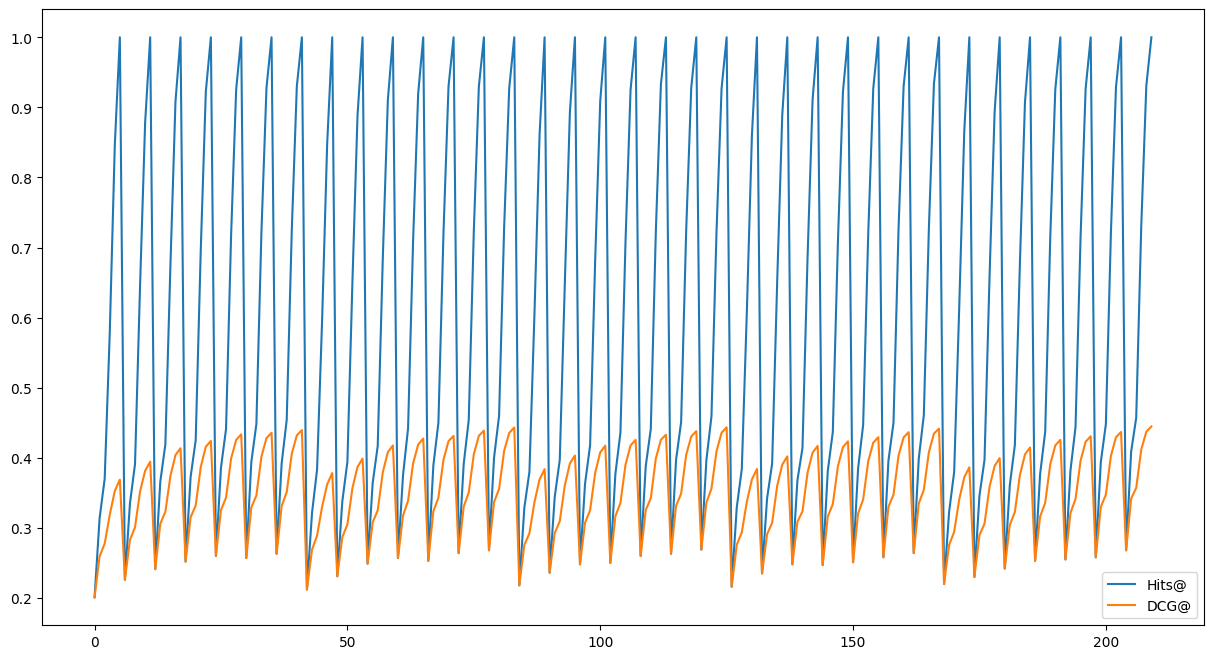

In [130]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.plot(hits_history)
plt.plot(dsg_history)
plt.legend(['Hits@', 'DCG@'])
plt.show()

### Замечание:
Решить эту задачу с помощью обучения полноценной нейронной сети будет вам предложено, как часть задания в одной из домашних работ по теме "Диалоговые системы".

Напишите свой вывод о полученных результатах.
* Какой принцип токенизации даёт качество лучше и почему?
* Помогает ли нормализация слов?
* Какие эмбеддинги лучше справляются с задачей и почему?
* Почему получилось плохое качество решения задачи?
* Предложите свой подход к решению задачи.

## Вывод:
